In [1]:
import tensorflow as tf

In [2]:
!nvidia-smi

Tue Jul 26 15:58:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
| 37%   46C    P2    62W / 260W |  10564MiB / 11019MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import librosa
import librosa.display
import math
import sys
import matplotlib.pyplot as plt 
#sys.path.insert(0,'/home/ikwak2/hmd/notebooks')
#sys.path.insert(0,'/home/ikwak2/hmd/iy_classifier')
sys.path.insert(0,'utils')
from helper_code import *
from get_feature import *
from models import *
from Generator0 import *
from keras.preprocessing import sequence

In [4]:
root_dir = 'physionet.org/files/circor-heart-sound/1.0.3'
training_data_file = root_dir + '/' + 'training_data.csv'
training_data_dir = root_dir + '/' + 'training_data'
model_dir = root_dir + '/' + 'model'

In [5]:
# data_folder =  'physionet.org/files/circor-heart-sound/1.0.3/training_data'
train_folder =  '/home/jk21/Downloads/Data/data/murmur/train'
test_folder = '/home/jk21/Downloads/Data/data/murmur/test'


In [6]:
model_folder = 'lcnn2'

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [8]:
patient_files_trn = find_patient_files(train_folder)
patient_files_test = find_patient_files(test_folder)

In [17]:
features_trn = get_features_3lb_all_rr_raw(train_folder,patient_files_trn[:10],use_rr=True)

 30%|█████████████▏                              | 3/10 [00:09<00:22,  3.16s/it]/home/jk21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jk21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 70%|██████████████████████████████▊             | 7/10 [00:22<00:09,  3.33s/it]/home/jk21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jk21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████| 10/10 [00:30<00:00,  3.08s/it]
/tmp/ipykernel_1143357/2016999572.py:47: VisibleDeprecationWarning: Creating an ndarr

In [21]:
for i in range(len(features_trn['rr1'])):
    print(len(features_trn['rr1'][i]))

25
13
16
44
20
29
33
32
38
45
32
31
17
15
9
45
30
35
58
24
40
37
50
40
37
54
28
28
10
18
21
27
26
42
40
34
26
38


In [26]:
data_folder=train_folder

In [22]:
from scipy import signal

In [23]:
age_classes = ['Neonate', 'Infant', 'Child', 'Adolescent', 'Young Adult']
recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']

num_patient_files = len(patient_files_trn)

current_patient_data = load_patient_data(patient_files_trn[200])
num_locations = get_num_locations(current_patient_data)
recording_information = current_patient_data.split('\n')[1:num_locations+1]


In [24]:
recording_information

['AV 50284_AV.hea 50284_AV.wav 50284_AV.tsv',
 'PV 50284_PV.hea 50284_PV.wav 50284_PV.tsv',
 'TV 50284_TV.hea 50284_TV.wav 50284_TV.tsv',
 'MV 50284_MV.hea 50284_MV.wav 50284_MV.tsv']

In [123]:
entries = recording_information[0].split(' ')
recording_file = entries[2]
filename = os.path.join(data_folder, recording_file)


In [124]:
____, recording1 = sp.io.wavfile.read(filename)

In [125]:
data = recording1

In [145]:
len(data)/4000

29.456

In [126]:
np.min(data)

-24216

In [127]:
np.max(data)

29415

In [157]:
peakind = signal.find_peaks_cwt(data[4000:8000],40)

In [158]:
peakind

array([ 701,  864, 1092, 1369, 1820, 2415, 2864, 3950])

In [159]:
np.diff(peakind)

array([ 163,  228,  277,  451,  595,  449, 1086])

In [160]:
data.shape

(117824,)

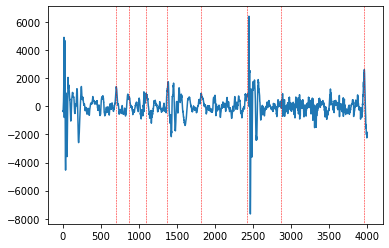

In [161]:
plt.plot(data[4000:8000])
for i in range(len(peakind)):
    plt.axvline(x=peakind[i],ymin=np.min(data), ymax=np.max(data),color='r', linestyle='--', linewidth=0.5)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

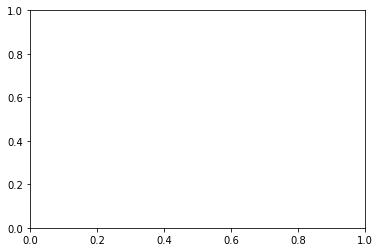

In [15]:
def get_features_3lb_all_rr_raw(data_folder, patient_files_trn, 
                          samp_sec=20, pre_emphasis = 0, hop_length=256, win_length = 512, n_mels = 100,
                          filter_scale = 1, n_bins = 80, fmin = 10, trim = 4000,
                         use_rr = False
                         ) :
    features = dict()
    features['id'] = []
    features['rr1'] = []
#    labels = []

    age_classes = ['Neonate', 'Infant', 'Child', 'Adolescent', 'Young Adult']
    recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']

    num_patient_files = len(patient_files_trn)

    for i in tqdm.tqdm(range(num_patient_files)):

        # Load the current patient data and recordings.
        current_patient_data = load_patient_data(patient_files_trn[i])
        num_locations = get_num_locations(current_patient_data)
        recording_information = current_patient_data.split('\n')[1:num_locations+1]
        for j in range(num_locations) :
            
            entries = recording_information[j].split(' ')
            recording_file = entries[2]
            filename = os.path.join(data_folder, recording_file)

            # Extract id
            id1 = recording_file.split('_')[0]
            features['id'].append(id1)

            try:
                ____, recording1 = sp.io.wavfile.read(filename)
                ____, info = nk.ecg_process(recording1, sampling_rate=4000)
                rr = np.diff(info['ECG_R_Peaks'])/4000
                current_rr = rr
            except:
                print(filename)
                current_rr=np.zeros((1))
                
            features['rr1'].append(current_rr)            
            


        
    for k1 in features.keys() :
        features[k1] = np.array(features[k1])    
    
    return features